# Exploration & Single Model Training

---


### Table of Contents:
- <a href='#1'>1. Read Data </a>
- <a href='#2'>2. Descriptive Statistics </a>
- <a href='#3'>3. Model Training </a>
- <a href='#4'>4. Results </a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from diffprivlib.models import LogisticRegression

# import from your own module
import sys
sys.path.append("../modules")
from utils import (load_and_preprocess_titanic,
                   calculate_private_statistics, 
                   plot_private_statistics,
                   plot_dp_metrics,
                   plot_dp_metrics_acc_f1,
                   plot_f1_score_comparison
                   )

# <a id='1'>1. Read Data</a>
-----

In [2]:
# Load Data
X, y = load_and_preprocess_titanic()
df = pd.concat([X, y], axis=1)

print("\nDescribe the dataset:")
print(df.describe())


Describe the dataset:
           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     2.308642    0.352413   29.361582    0.523008    0.381594   32.204208   
std      0.836071    0.477990   13.019697    1.102743    0.806057   49.693429   
min      1.000000    0.000000    0.420000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   22.000000    0.000000    0.000000    7.910400   
50%      3.000000    0.000000   28.000000    0.000000    0.000000   14.454200   
75%      3.000000    1.000000   35.000000    1.000000    0.000000   31.000000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.329200   

         Embarked    Survived  
count  891.000000  891.000000  
mean     1.536476    0.383838  
std      0.791503    0.486592  
min      0.000000    0.000000  
25%      1.000000    0.000000  
50%      2.000000    0.000000  
75%      2.000000    1.

# <a id='2'>2. Descriptive Statistics</a>
-----

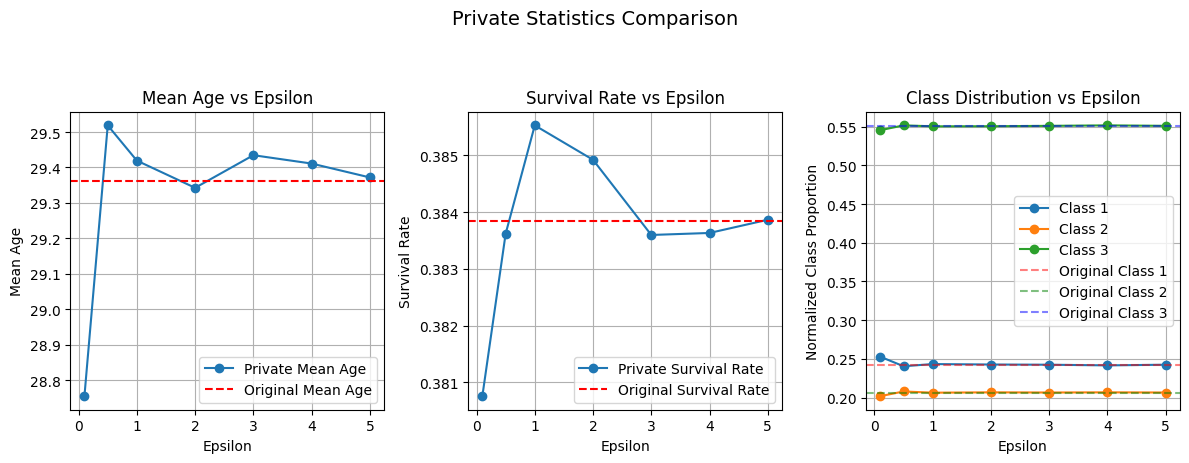

In [3]:
# Define epsilon values to test
epsilon_values = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

# Original statistics
original_mean_age = df['Age'].mean()
original_survival_rate = df['Survived'].mean()
original_class_counts = df['Pclass'].value_counts(normalize=True).sort_index()

original_stats = (original_mean_age, original_survival_rate, original_class_counts)

# Calculate private statistics
private_stats = calculate_private_statistics(df, epsilon_values)

# Plot statistics
plot_private_statistics(epsilon_values, original_stats, private_stats)

# <a id='3'>3. Model Training</a>
-----

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

In [5]:
# Train a non-private LogisticRegression (sklearn) and get baseline metrics
non_private_model = SklearnLogisticRegression()
non_private_model.fit(X_train, y_train)

non_private_preds = non_private_model.predict(X_test)
non_private_metrics = {
    'accuracy': accuracy_score(y_test, non_private_preds),
    'precision': precision_score(y_test, non_private_preds),
    'recall': recall_score(y_test, non_private_preds),
    'f1': f1_score(y_test, non_private_preds)
}

In [6]:
# Compute data_norm for diffprivlib
data_norm = np.linalg.norm(X_train, axis=1).max()

# Sweep over epsilon values and collect private metrics
epsilon_values = np.logspace(-2, 4, 300)
private_metrics = []

for eps in epsilon_values:
    dp_model = LogisticRegression(epsilon=eps, data_norm=data_norm)
    dp_model.fit(X_train, y_train)
    dp_preds = dp_model.predict(X_test)
    
    metrics = {
        'epsilon': eps,
        'accuracy': accuracy_score(y_test, dp_preds),
        'precision': precision_score(y_test, dp_preds, zero_division=0),
        'recall': recall_score(y_test, dp_preds),
        'f1': f1_score(y_test, dp_preds)
    }
    private_metrics.append(metrics)

private_metrics_df = pd.DataFrame(private_metrics)
private_metrics_df

,epsilon,accuracy,precision,recall,f1
0,0.010000,0.670391,0.592593,0.648649,0.619355
1,0.010473,0.541899,0.300000,0.081081,0.127660
2,0.010968,0.413408,0.413408,1.000000,0.584980
3,0.011487,0.508380,0.452703,0.905405,0.603604
4,0.012030,0.441341,0.395161,0.662162,0.494949
...,...,...,...,...,...
295,8312.514990,0.787709,0.772727,0.689189,0.728571
296,8705.612479,0.810056,0.727273,0.864865,0.790123
297,9117.299485,0.815642,0.773333,0.783784,0.778523
298,9548.455103,0.798883,0.779412,0.716216,0.746479


# <a id='4'>4. Results</a>
-----

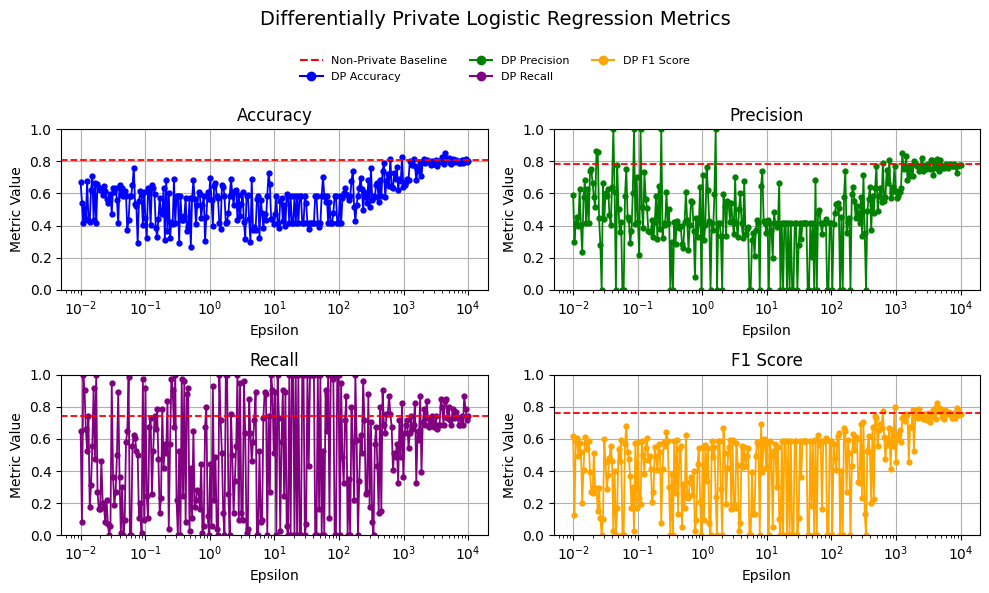

In [7]:
# Plot the metrics vs epsilon
img_path = '../plots/dp_log_reg_metrics.png'
plot_dp_metrics(private_metrics_df, non_private_metrics, img_path)

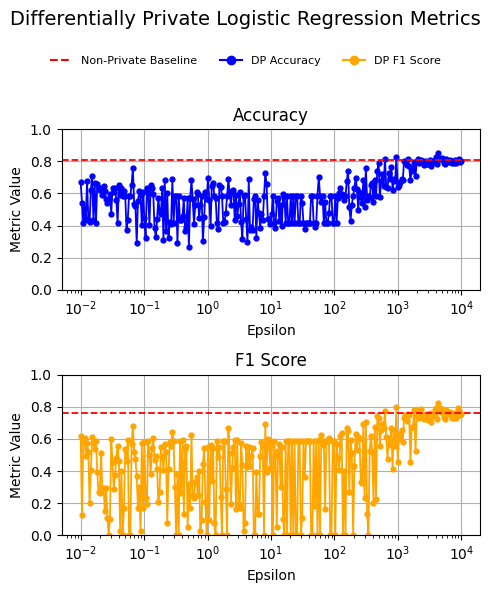

In [8]:
# Plot only Accuracy and F1-score
img_path = '../plots/dp_log_reg_metrics_acc_f1.png'
plot_dp_metrics_acc_f1(private_metrics_df, non_private_metrics, img_path)

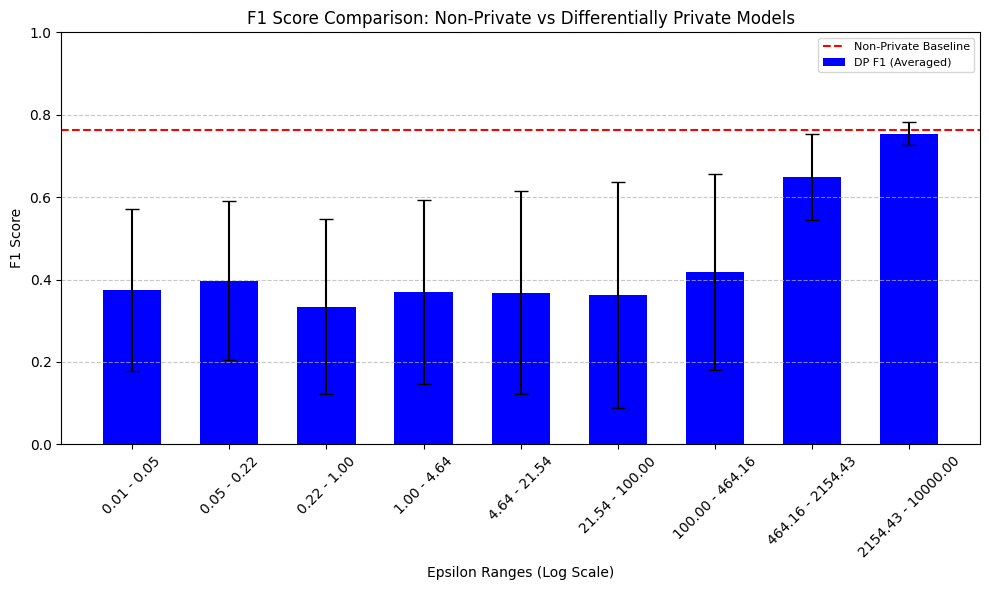

In [9]:
# Plot the f1 score comparison
img_path = '../plots/dp_log_reg_f1_comparison.png'
plot_f1_score_comparison(private_metrics_df, non_private_metrics, img_path)